In [1]:
from database.connect import getConnection
import mysql
import pandas as pd
from pathlib import Path
import csv

In [2]:
try:
    connection = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

cursor = connection.cursor()

In [3]:
min_tweets = 10
file_path = Path("./data/sentiment_per_pos.csv")

# check if the file exists
my_file = file_path
if not my_file.is_file():
    # create the file if it doesn't exist
    with open(file_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["position", "sentiment"])
    # get all the tweet sentiment per position
    i = 1
    while True:
        # get all the sentiment of tweets in position i
        query = f"""
        SELECT DISTINCT tweets.id, sentiment
        FROM tweets, part_of
        WHERE tweets.id = part_of.tid
        AND part_of.position = {i};
        """
        cursor.execute(query)
        dirty_result = cursor.fetchall()
        clean_result = [x[1] for x in dirty_result]
        if len(clean_result) < min_tweets:
            break
        # write the sentiment to a csv file
        with open(f"./data/sentiment_per_pos.csv", "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([i, clean_result])

        i += 1

In [4]:
# for each position, get 75%, 50%, 25% percentile
df = pd.read_csv("./data/sentiment_per_pos.csv")
df["sentiment"] = df["sentiment"].apply(lambda x: eval(x))
df["75%"] = df["sentiment"].apply(lambda x: pd.Series(x).quantile(0.75))
df["50%"] = df["sentiment"].apply(lambda x: pd.Series(x).quantile(0.50))
df["25%"] = df["sentiment"].apply(lambda x: pd.Series(x).quantile(0.25))

Text(0.5, 1.0, 'Sentiment over time')

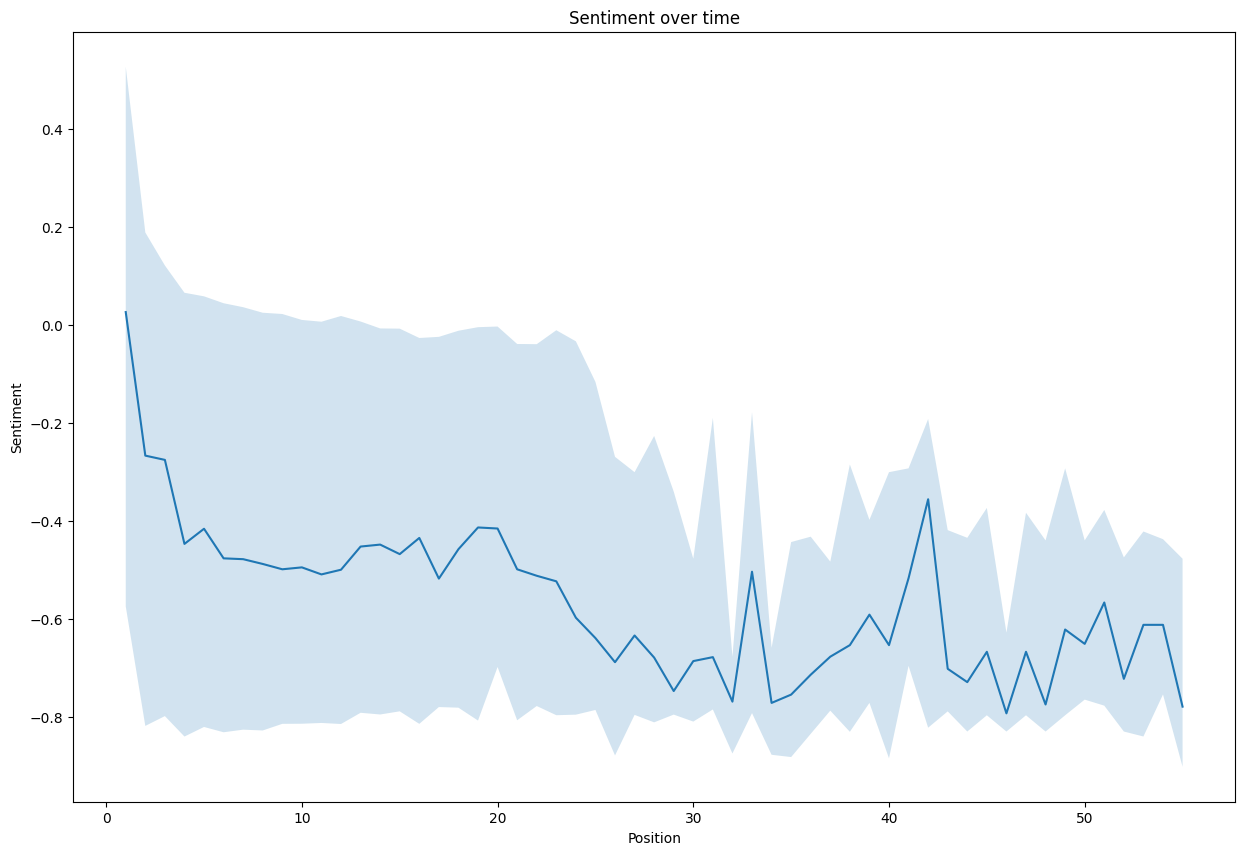

In [5]:
# plot the linegraph, colouring the area between 75% and 25%
ax = df.plot(x="position", y="50%", figsize=(15, 10), legend=False)
ax.fill_between(df["position"], df["75%"], df["25%"], alpha=0.2)
ax.set_xlabel("Position")
ax.set_ylabel("Sentiment")
ax.set_title("Sentiment over time")


In [6]:
# close the connection
connection.close()